#### Architecture - Semantic Search using Elastic Search


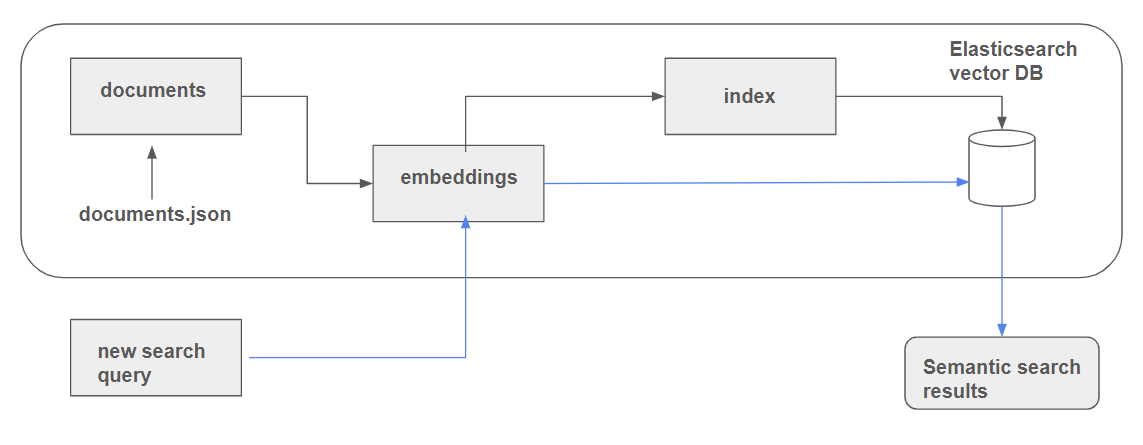

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

#### Step 1: Prepare documents

In [1]:
import json

with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [2]:
len(docs_raw[0:3])

3

In [3]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

In [3]:
documents[0:6]

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp'},
 {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'section': 'General course-related questions',
  'question': 'Course - What are the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp'},
 {'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines 

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [4]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

In [5]:
len(model.encode("This is a simple sentence"))

768

In [12]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

In [6]:
#created the dense vector using the pre-trained model
# Take some time (atleast a couple of minutes to run)
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

In [14]:
operations[0:6]

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp',
  'text_vector': [-0.035703469067811966,
   -0.06891430914402008,
   -0.04448341950774193,
   0.006250144448131323,
   -0.042247090488672256,
   -0.006454006303101778,
   0.027548134326934814,
   -0.018610283732414246,
   -0.052037473767995834,
   -0.0024047456681728363,
   0.05745450034737587,
   -0.015592584386467934,
   0.015488812699913979,
   0.0987015962600708,
   0.015

#### Step 3: Setup ElasticSearch connection 

In [13]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '8ee65127cc7c', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'xpqbNiK5RPul2xQvyJP14g', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [14]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [15]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

#### Step 5: Add documents into index

In [16]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [17]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [18]:
# Passing the vector embeddings to the search function results in semantic search
# On the other hand, passing the actual input text to the search function results in keyword search
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [19]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'pPoqxJABtoZT4MvR7M6A',
  '_score': 0.71479183,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 't_osxJABtoZT4MvRzNH1',
  '_score': 0.61347336,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares 

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [20]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [22]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"}, # We can substitute any documents fields to filter the results
                                                                  # Example - "course" : "data-engineering-zoomcamp"
    },
    knn=knn_query,
    size=5,
    explain = True # Will add a field on how the _score value was derived. We can also customize the scoring function
)

In [23]:
response["hits"]["hits"]

[{'_shard': '[course-questions][0]',
  '_node': 'rR6dv6F0S3aouBEf8i9VZg',
  '_index': 'course-questions',
  '_id': 'pPoqxJABtoZT4MvR7M6A',
  '_score': 11.614713,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965485885739326,
    -0.0006261198432184756,
    -0.016629479825496674,
    0.052851513028144836,
    0.054765306413173676,
    -0.03133990615606308,
    0.029942603781819344,
    -0.04808563366532326,
    0.04467551410198212,
    0.005839459598064423,
    0.016233060508966446,
    0.012001175433397293,
    -0.03122228942811489,
    0.01660051941871643,
    -0.04886902868747711,
    -0.06496305018663406,
    0.04643420875072479,
    -0.009297742508351803,
    -0.06425285339355469,
    -0.01373269874602556

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch